In [1]:
# 6-9. 프로젝트: CAM을 만들고 평가해 보자

[CAM, Grad-CAM, Grad-CAM 리뷰](https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp)

In [2]:
# 사용할 버전 라이브러리 버전을 확인!

import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


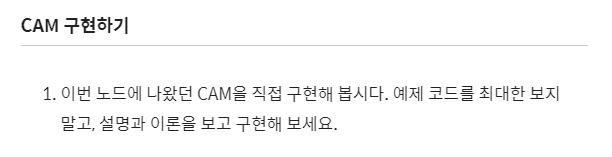

**1. 데이터셋 준비하기**

CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)과 소프트맥스 레이어가 붙는 형태로 구성되어야 한다는 제약이 있다.
반면에 Grad-CAM은 이러한 제약이 없다.

CAM은 클래스에 대한 활성화 정도를 나타낸 지도이다.

기본적으로 우리의 모델은 분류(classfication)를 수행하는 모델이어야 한다.

Stanford_dogs 데이터셋을 사용하는데, 여기는 120종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있다.

In [3]:
!mkdir -p ~/aiffel/class_activation_map/data

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# stanford_dogs 데이터셋 다운로드



stanford_dogs 데이터셋은 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋으로 구성되어 있다. tfds.load()를 활용해서 데이터셋을 다운로드 진행

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train','test'],
    shuffle_files = True,
    with_info = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSIK6IB/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSIK6IB/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [8]:
# tfds.show_examples()를 통해서 각 이미지의 클래스와 그 인덱스를 확인!

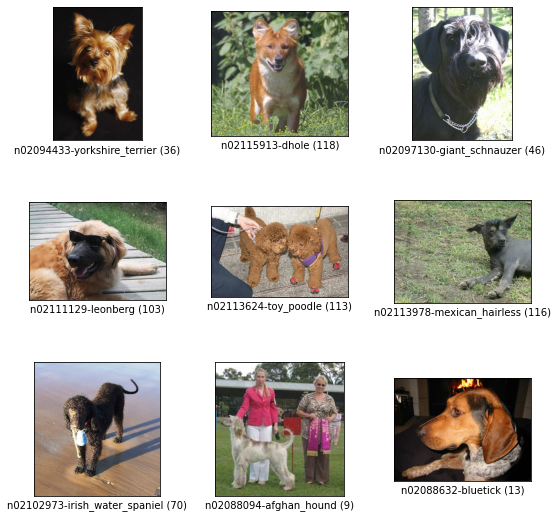

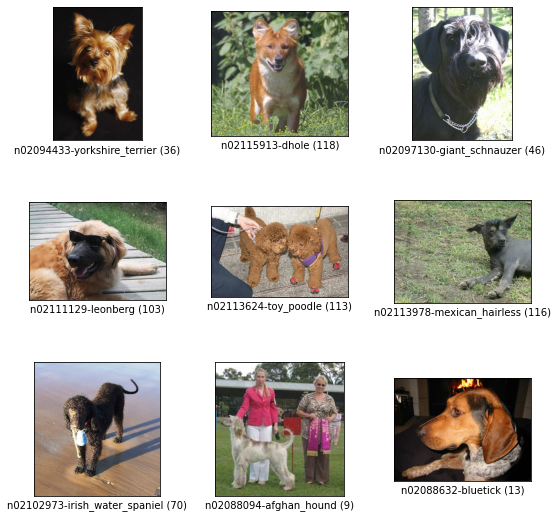

In [9]:
tfds.show_examples(ds_train, ds_info)

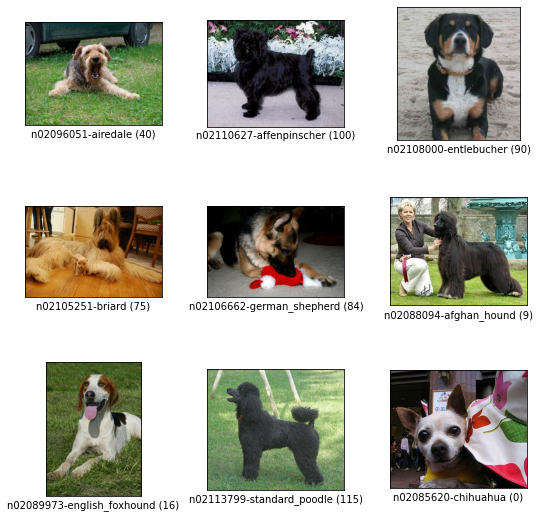

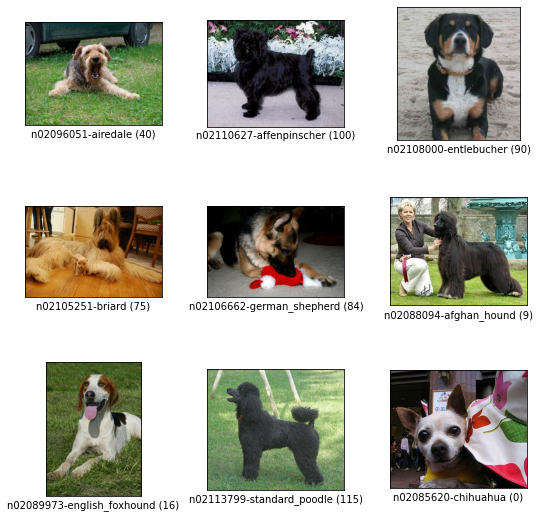

In [10]:
# 평가용 데이터셋도 확인가능
tfds.show_examples(ds_test, ds_info)

**2. 물체의 위치정보**

df_info를 조회해 features가 어떻게 구성되어 있는지 확인

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [12]:
ds_info.features['label'].names # 데이터 셋의 강아지 품종 확인

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

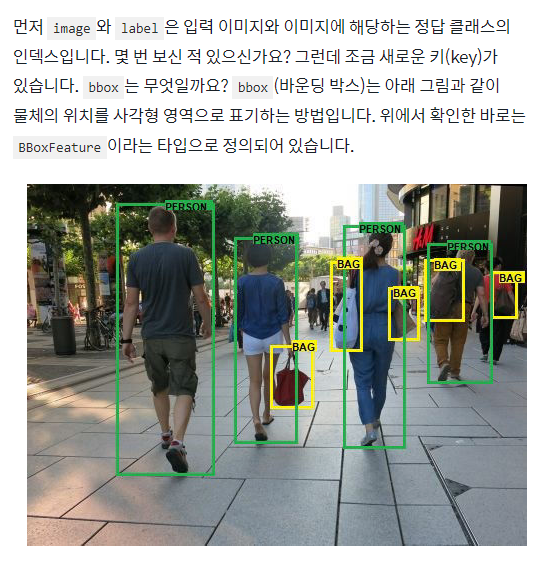

**3. CAM을 위한 모델 만들기**

본격적으로 CAM을 얻어내기 위한 모델을 만든다.

ImageNet 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 
Pooling layer 뒤에 softmax layer를 붙여 Grad-CAM을 만든다.

참고로, softmax layer는 softmax 함수를 activation funtion으로 사용하는 fully connected layer이다.



In [13]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top = False,   # Imagenet 분류기 fully connected layer 제거
    weights='imagenet', # imagenet 훈련된 가중치 가져오기
    input_shape=(224,224,3),
    pooling='avg',    # GAP를 적용
)

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 한다. 여기서는 ResNet50의 매개변수 pooling에 'avg'를 매개 변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있다.

In [14]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

위의 모델 구조에서 conv5_block3_out이 feature map이 된다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행 한다.

**4. CAM 모델 학습하기**

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img()에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성한다.

input에 이전과 다르게 bbox 정보가 포함되어 있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img 과정에서 제외해 주었다. 

CAM 모델은 object detection이나 segementation에도 활용될수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.



[tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)

In [15]:
def normalize_and_resize_img(input):
  # Normalizes images: 'uint8' -> 'float32'
  image = tf.image.resize(input['image'], [224,224])
  input['image'] = tf.cast(image, tf.float32) / 255.
  return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds


In [16]:
# 데이터셋에 전처리와 배치처리를 적용한다.

ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 본다.
for input in ds_train_norm.take(1):
  image, label = input
  print(image.shape)
  print(label.shape)

(16, 224, 224, 3)
(16,)


In [17]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch =int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 104s 120ms/step - loss: 2.2124 - accuracy: 0.4493 - val_loss: 3.7024 - val_accuracy: 0.1692
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.6744 - accuracy: 0.8201 - val_loss: 1.0479 - val_accuracy: 0.6917
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.1819 - accuracy: 0.9653 - val_loss: 0.9169 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0461 - accuracy: 0.9973 - val_loss: 0.9132 - val_accuracy: 0.7331
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0198 - accuracy: 0.9998 - val_loss: 0.8899 - val_accuracy: 0.7421
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.9032 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9363 - val_a

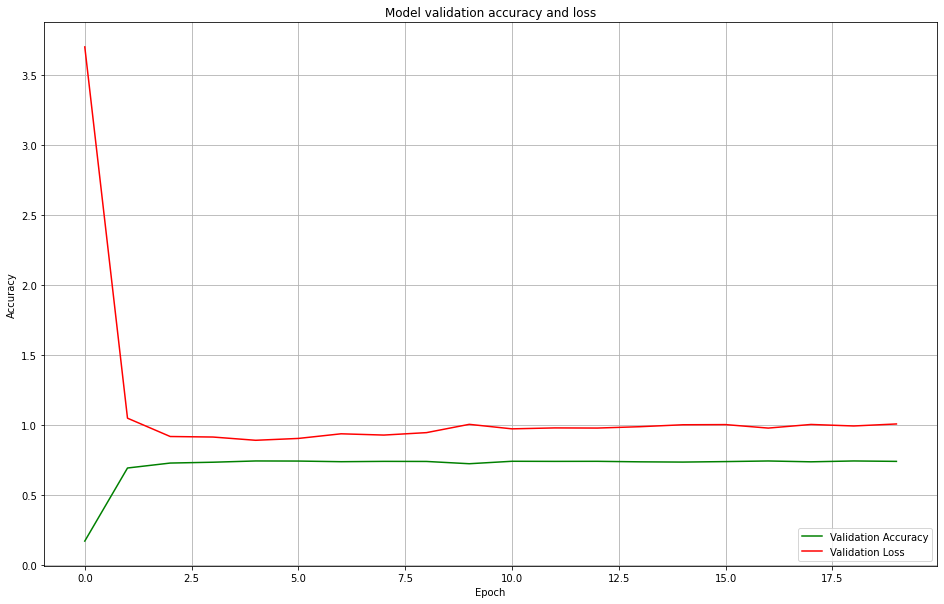

In [19]:
plt.figure(figsize=(16,10))

plt.plot(history_cam_model.history['val_accuracy'], 'g')
plt.plot(history_cam_model.history['val_loss'], 'r')

plt.title('Model validation accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation Accuracy','Validation Loss'], loc='lower right')

plt.grid(True)
plt.show()

In [20]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


.h5 이란?



*   학습 시킨 model을 파일로 저장할 때, 보통 .h5 확장자로 저장한다.
.h5 확장자는, HDF5 포맷으로 데이터를 저장한다는 것을 의미

* .h5 파일은 모델 및 가중치(weight)를 모두 가지고 있다.   

In [21]:
def generate_cam(model, item):
  cam_image = None
  
  return cam_image

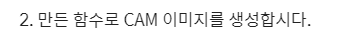

학습된 모델에서 CAM을 생성한다. CAM 생성은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_take_one()함수로 데이터셋에서 한 장씩 뽑을수 있도록 한다.

In [22]:
def get_take_one(ds):
  ds = ds.take(1)
  sample_data = list(ds.as_numpy_iterator())
  bbox = sample_data[0]['objects']['bbox']
  image = sample_data[0]['image']
  label = sample_data[0]['label']
  return sample_data[0]

108


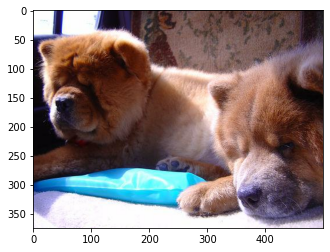

In [54]:
item = get_take_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [55]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 

1. 특성맵
2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값이 필요

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것이다.

이를 고려해서 model과 item을 받았을때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.

generate_cam()을 구현하기 위해서 아래에서는 conv_outputs과 같이 특정 레이어의 결괏값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 reisize

In [56]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## 학습한 모델에서 원하는 layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolutuon layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation 가져오기
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f를 통해 class별 activation map 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize하기
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

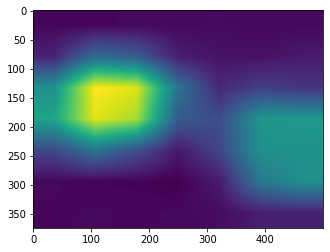

In [57]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

정확한 위치에 표현됨을 알수 있다.

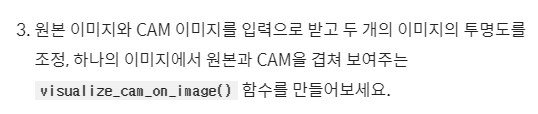

[opencv - 2개 이미지 블렌딩하기](https://webnautes.tistory.com/1245)

In [58]:
# import cv2 as cv

# a = 0.0

# while(a <= 1.0):
#     img1 = cv.imread('cat.jpg')
#     img2 = cv.imread('background.jpg')

#     # 블렌딩하는 두 이미지의 크기가 같아야함
#     width = img1.shape[1]
#     height = img1.shape[0]
#     img2 = cv.resize(img2, (width, height))

#     # img1 사진은 점점 투명해지고 img2 사진은 점점 불투명해짐
#     b = 1.0 - a
#     dst = cv.addWeighted(img1, a, img2, b, 0)
#     cv.imshow('dst',dst)
#     cv.waitKey(0)

#     print( a, " ", b)

#     a = a + 0.2


# cv.destroyAllWindows()

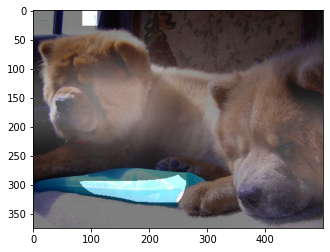

In [59]:
# visualize_cam_on_image() 함수 사용
def visualize_cam_on_image(src1, src2, alpha=0.5): # src : img 태그 안에 src 속성은 이미지가 저장 되있는 경로를 속성값으로 요구한다.
  beta = (1.0 - alpha)
  merged_image =cv2.addWeighted(src1, alpha, src2, beta, 0.0)
  return merged_image

# type(item['image'].numpy())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

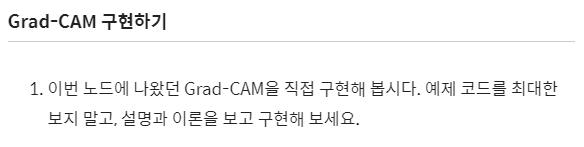

이번에는 Grad-CAM을 이용해서 CAM을 얻는다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용한다.

이번에는 Grad-CAM을 이용해서 CAM을 만든다.

grad_cam은 관찰을 원하는 layer와 정답 클래스에 대한 예측값 사이의 gradient를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 layer의 채널별 가중치를 구한다. 최종 CAM 이미지를 구하기 위해서는 layer의 채널별 가중치(weights)와 layer에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다.

이번 스텝에서 본 CAM 함수와는 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, gradient 계산을 원하는 관찰 대상 layer activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 gradient grad_val을 얻고 이를 weights로 활용한다.

In [60]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻는다.
        output = conv_output[0] # 원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻는다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [61]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

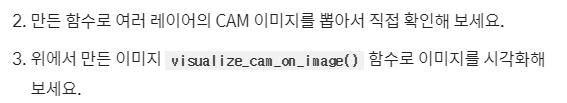

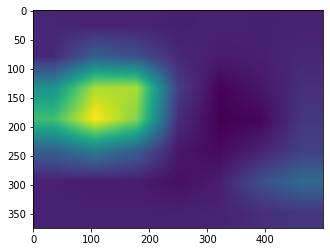

In [62]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

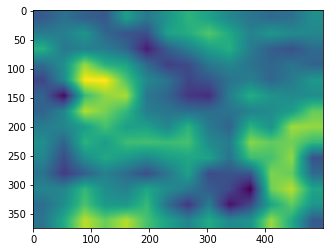

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

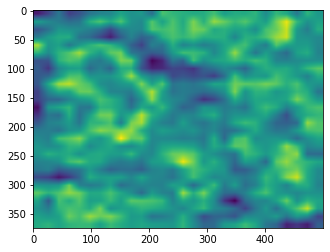

In [64]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

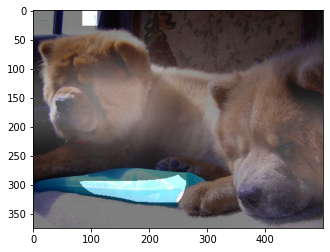

In [65]:
# visualize_cam_on_image() 함수 사용
def visualize_cam_on_image(src1, src2, alpha=0.5): # src : img 태그 안에 src 속성은 이미지가 저장 되있는 경로를 속성값으로 요구한다.
  beta = (1.0 - alpha)
  merged_image =cv2.addWeighted(src1, alpha, src2, beta, 0.0)
  return merged_image

# type(item['image'].numpy())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

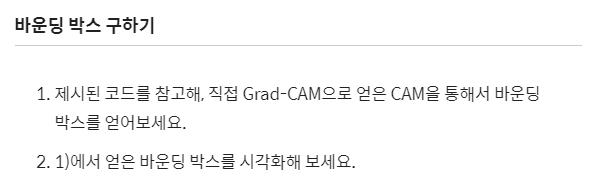

108


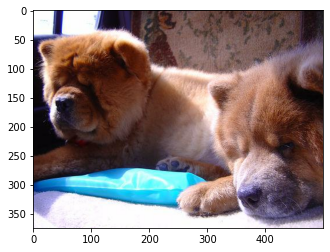

In [66]:
item = get_take_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

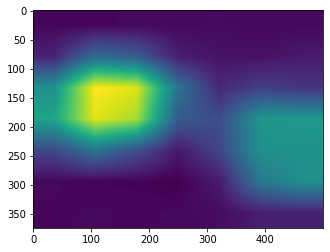

In [67]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑았다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스를 없앤다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다. 이때 rotated_rect라는 회전된 바운딩 박스를 얻을 수 있다.
boxpoints()로 이를 꼭기점으로 바꾸어 준다. 마지막에는 int 자료형으로 변환

In [68]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [69]:
# cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습
rect = get_bbox(cam_image)
rect

array([[496, 389],
       [-33, 323],
       [  5,  12],
       [536,  79]])

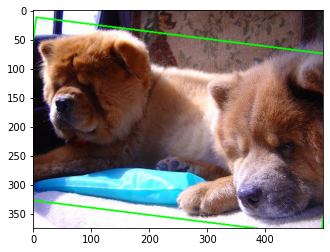

In [70]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0.0,255), 2)
plt.imshow(image)
plt.show()

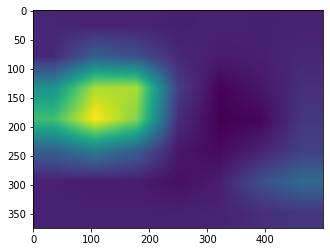

In [71]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [72]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[348, 374],
       [348, 141],
       [499, 141],
       [499, 374]])

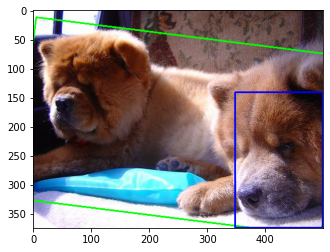

In [73]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

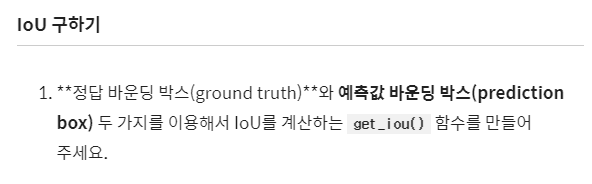

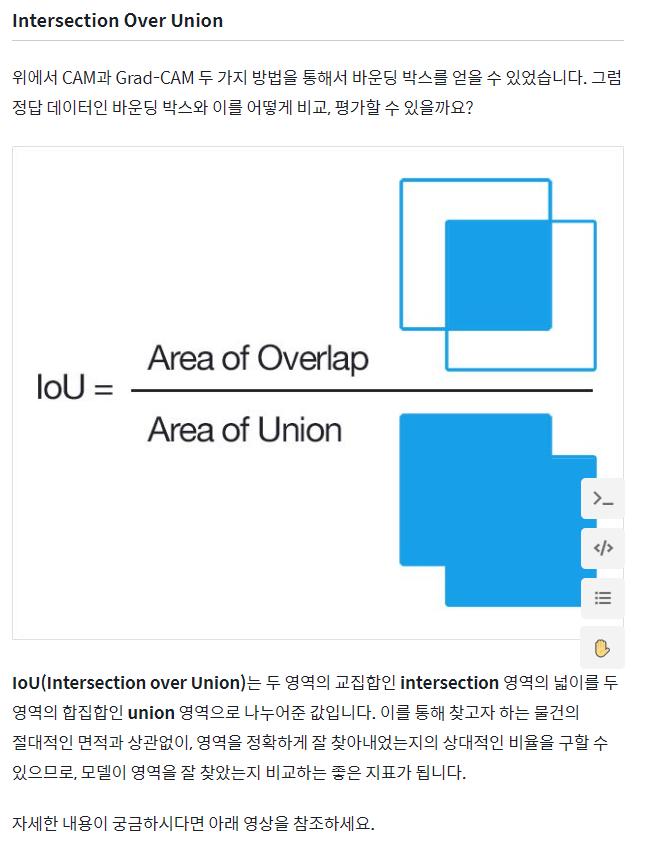

In [74]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [75]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.032, -0.066, 1.0373333333333334, 1.072]

In [76]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.376, 0.696, 0.9973333333333333, 0.998]

In [77]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [78]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.37207533608848287

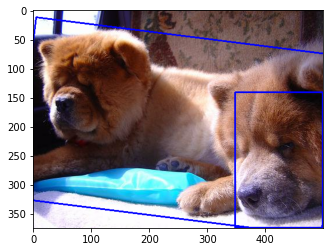

In [79]:
cam_image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(cam_image)
plt.show()

In [80]:
# grad_cam_image를 통한 bbox를 minmax bbox 형태로 치환
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
pred_bbox

[0.032, -0.066, 1.0373333333333334, 1.072]

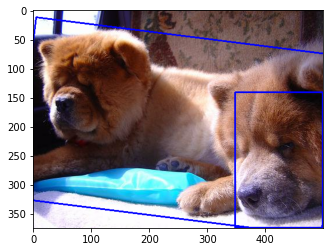

In [81]:
grad_cam_image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(grad_cam_image)
plt.show()

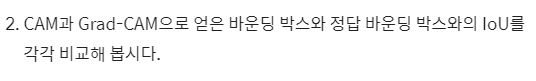

In [82]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.37207533608848287

In [83]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])


0.408823087183786

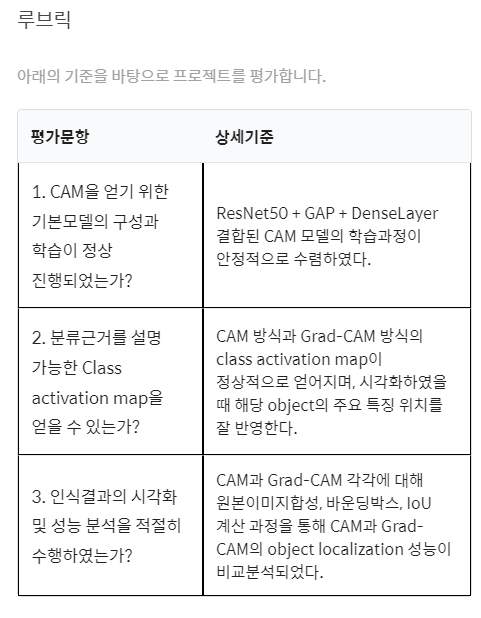

기본적으로 모든 루브릭을 만족할 만큼의 결과를 얻을수 있었다. CAM과 Grad-CAM 모두에서 object detection이 제대로 수행되었고 한 사진상에서 강아지가 2마리일 경우 모두 오히려 CAM에서 detection이 잘되는 양상이었다. 

IOU에서는 Grad-CAM의 약간 더 높은 값을 보여주었는데 IOU값이 높을수록 얼굴같은 특징을 더 잘 찾는다고 볼 수 있었다.

Grad-CAM 같은 경우에는 마지막이 아닌 conv_ouputs과 같이 특정 레이어에서의 결과인 feature map을 다 뽑아볼수 있는데, 여력이 되지 않아 다 해보지는 못하였다.

풀링 기법중에서 Max pooling과 Average pooling중 항상 Max pooling이 짱이고 가장 많이 쓰이고 Avg pooling은 거의 쓰이지 않는다고 알고 있었고 배워왔는데, 본 논문과 연구 결과에서는 Avg pooling이 classification을 해결하기 위해 학습된 네트워크에서 localization하기 위한 목적으로 활용될수 있다는 점을 깨닫게 해준 것은 아직 이 분야에서 아는게 없는 수준이라는 것을 방증하는 것이라는 생각이 들었다.

https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp 구동원리를 알기 위해서는 역시 수학이 중요하다.

확률통계학과 선형대수 미적분이 적절하게 조화된 지식만이 완벽한 이해를 가져와줄 것 같다.